# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse PFC cells

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [2]:
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)

## Input data

In [3]:
import calculation_tool as ct
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

In [ ]:
#old 
#file_path="/temp/data/mouse_PFC/WT_PFC_adata.h5ad"
#adata = anndata.read_h5ad(file_path)

#GPCR_file_path="/temp/data/mouse_PFC/WT_PFC_GPCR_adata.h5ad"
#GPCR_adata = anndata.read_h5ad(GPCR_file_path)

In [4]:
file_path=r"/data/mouse_PFC/combined_data_processed.h5ad"
adata = anndata.read_h5ad(file_path)

GPCR_file_path=r"/data/mouse_PFC/combined_data_GPCR_df.csv"
GPCR_df = pd.read_csv(GPCR_file_path, index_col=0)
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)

In [ ]:
dir="/temp/data/mouse_PFC"
GPCR_adata_norm_df=pd.read_csv((os.path.join(dir,"GPCR_adata_norm_df.csv")),index_col=0)
new_columns = [col.split('_')[0] for col in GPCR_adata_norm_df.columns]
GPCR_adata_norm_df.columns=new_columns


In [5]:
from tqdm import tqdm  # 追加：進捗バー用ライブラリ

def sim_inhibit_pattern(adata, GPCR_adata_norm_df, GPCR_type_df, drug_conc,n_pattern=100):
    # 1. adata.obs の "is_clz_selective" に基づき、グループ分けするためのマスクを作成
    mask = adata.obs['is_clz_selective'] == True

    # 2. GPCRのリストおよび GPCR_type_df のフィルタリング
    # "Unnamed: 0" を除外したカラムリストを作成
    GPCR_list2 = [col for col in GPCR_adata_norm_df.columns if col != "Unnamed: 0"]
    GPCR_type_df = GPCR_type_df[GPCR_type_df.receptor_name.isin(GPCR_list2)]
    Gs = GPCR_type_df[GPCR_type_df.type == "Gs"]["receptor_name"].values
    Gi = GPCR_type_df[GPCR_type_df.type == "Gi"]["receptor_name"].values

    # 3. ランダムな受容体阻害パターンを 10,000 パターン生成
    unique_patterns_set = set()
    pattern_dict = {}
    i = 0
    while len(unique_patterns_set) < n_pattern:
        random_pattern = np.random.randint(2, size=len(GPCR_list2))
        pattern_str = ''.join(map(str, random_pattern))
        if pattern_str not in unique_patterns_set:
            unique_patterns_set.add(pattern_str)
            # 各パターンは、受容体ごとに True (阻害する) / False (阻害しない) の辞書とする
            pattern_dict[f"Pattern_{i+1}"] = {gpcr: bool(val) for gpcr, val in zip(GPCR_list2, random_pattern)}
            i += 1

    # オプション：最初の5パターンを確認
    for key in list(pattern_dict.keys())[:5]:
        print(f"{key}: {pattern_dict[key]}")

    # 4. 全細胞の GPCR 発現データ（正規化済み）の DataFrame を用意
    # ※ GPCR_adata_norm_df の index と adata.obs_names が整合している前提
    all_expr = pd.DataFrame(GPCR_adata_norm_df, index=GPCR_adata_norm_df.index, columns=GPCR_list2)

    # 5. 全細胞に対する cAMP 変化（cAMP modulation）をシミュレーションする関数の定義
    def simulate_response_all(expression_df, pattern, drug_conc, Gs, Gi):
        """
        expression_df: 各細胞の受容体発現 (DataFrame, 行=細胞, 列=受容体)
        pattern: 受容体阻害パターン（辞書, receptor -> bool, True=阻害する）
        drug_list: 薬剤名のリスト
        drug_conc: 薬剤濃度（scalar）
        Gs, Gi: Gs, Gi タイプ受容体名の配列
        """
        # 阻害パターンに応じた effective Ki の設定
        # 阻害する受容体は Ki = 0.01、阻害しない受容体は Ki = 10000
        #effective_Ki = pd.Series({receptor: (0.01 if pattern[receptor] else 10000)
        #                          for receptor in expression_df.columns})
        effective_Ki = pd.Series({
        receptor: (0.01 if pattern[receptor] else 10000)
        for receptor in expression_df.columns
        })
        #print(effective_Ki)
        responses = {}
        # 各薬剤について、Gs 効果・Gi 効果を計算
        gs_effect = (expression_df[Gs].divide(1 + drug_conc / effective_Ki[Gs])).sum(axis=1)
        gi_effect = (expression_df[Gi].divide(1 + drug_conc / effective_Ki[Gi])).sum(axis=1)
        basal_cAMP = (expression_df[Gs] - expression_df[Gi]).sum(axis=1)
        cAMPmod = (gs_effect - gi_effect) - basal_cAMP
        print("cAMPmod")
        
        # 各薬剤の結果は、細胞ごとの cAMPmod の Series とする
        responses= cAMPmod
        return responses

    # 6. 各阻害パターンについて、全細胞でシミュレーションした後、clz_selective と非選択細胞間の差分を算出
    results = []
    # adata.obs のインデックスと all_expr のインデックスが一致しない可能性があるため、再インデックスする
    mask_aligned = mask.reindex(all_expr.index, fill_value=False)
    
    # tqdm を用いて進捗状況を表示
    for pattern_name, pattern in tqdm(pattern_dict.items(), total=len(pattern_dict), desc="Simulating drug responses"):
        # 全細胞でのシミュレーション結果を得る
        all_responses = simulate_response_all(all_expr, pattern, drug_conc, Gs, Gi)
        print(all_responses)
        # 各薬剤について、mask_aligned を用いて clz_selective と非選択細胞群の平均値を計算
        selective_mean = all_responses[mask_aligned].mean()
        nonselective_mean = all_responses[~mask_aligned].mean()
        diff= selective_mean - nonselective_mean
        #print(diff)
        results.append({
            'pattern_name':pattern_name,
            'pattern': pattern,
            'diff': diff
        })

    # 7. 結果を DataFrame に変換し、diff の大きい順にソート
    results_df = pd.DataFrame(results)
    results_df_sorted = results_df.sort_values(by='diff', ascending=False)

    # 上位のパターンを確認（例：上位5件）
    print(results_df_sorted.head())

    return results_df_sorted,all_responses


In [6]:
import calculation_tool as ct

drug_conc=10**4
results_df_sorted,all_responses=ct.sim_inhibit_pattern(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,n_pattern=10000)

Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': False, 'HTR5A_raw': True, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': True, 'DRD2_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': True, 'HRH2_raw': False, 'HRH3_raw': True, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': True, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': True, 'ADRA2A_raw': True, 'ADRA2C_raw': True, 'ADRB1_raw': True, 'ADRB2_raw': True}
Pattern_2: {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1D_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': True, 'DRD1_raw': True, 'DRD2_raw': True, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': True, 'HRH3_raw': True, 'CHRM1_raw': False, 'CHRM2_raw': True, 'CHRM3_raw': True, 'CHRM5_raw': True, 'ADRA1A_raw': Tr

Simulating drug responses: 100%|██████████| 10000/10000 [03:56<00:00, 42.37it/s]


      pattern_name                                            pattern  \
71      Pattern_72  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
7873  Pattern_7874  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
2315  Pattern_2316  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   
9923  Pattern_9924  {'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...   
2989  Pattern_2990  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   

             diff  
71    2977.992662  
7873  2959.012964  
2315  2957.994650  
9923  2954.102794  
2989  2937.462503  


In [7]:
dir="/data/mouse_PFC"
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses.csv"))

In [133]:
results_df_sorted

,pattern_name,pattern,diff
15,Pattern_16,"{'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...",2690.925864
40,Pattern_41,"{'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...",2635.198313
12,Pattern_13,"{'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...",2476.771231
38,Pattern_39,"{'HTR1A_raw': True, 'HTR1B_raw': True, 'HTR1D_...",2381.982290
41,Pattern_42,"{'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...",2362.728561
46,Pattern_47,"{'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...",2337.113118
8,Pattern_9,"{'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...",2317.699985
24,Pattern_25,"{'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...",2292.837909
19,Pattern_20,"{'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...",2253.108151
4,Pattern_5,"{'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...",2242.225193


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def visualize_patterns(results_df_sorted, top_n=None, top_n_for_heatmap=None, scatter_n=None):
    """
    Parameters:
      results_df_sorted: DataFrame with columns 'pattern_name', 'pattern', 'diff'
                         'pattern' は {'HTR1A_raw': True/False, ...} の辞書形式とする
      top_n: ヒートマップ（従来版）および棒グラフで表示する上位パターン数（Noneの場合は全パターン）
      top_n_for_heatmap: 拡大版ヒートマップで表示する上位パターン数（Noneの場合は表示しない）
      scatter_n: 散布図にプロットするパターン数（Noneの場合は全パターン）
    
    Display:
      1. ヒートマップ（従来版）:
         - X軸: 受容体名（"_raw" を除去）、X軸ラベルは90°回転
         - Y軸: diff が大きい順のパターン番号（1,2,3,...）
         - 二値（True/False）の離散カラーマップを使用し、legend を右側に配置（余白を確保）
      2. ヒートマップ（拡大版）:
         - top_n_for_heatmap で指定した上位パターンを表示（従来版と同様の設定）
      3. 棒グラフ:
         - top_n パターン中の各受容体の True の割合 (%) を表示
         - ヒートマップと同じ横幅、X軸ラベルは90°回転、右側に空の legend を配置
      4. 散布図:
         - scatter_n に指定したパターン数（または全パターン）の diff 値をプロット
         - X軸はパターン番号（diff が大きい順、1～）、ラベルは90°回転
    """
    # 1,2,3 用のデータ（ヒートマップ（従来版）および棒グラフ）は top_n を使用（top_n が None の場合は全パターン）
    if top_n is not None:
        df_subset = results_df_sorted.head(top_n).reset_index(drop=True)
    else:
        df_subset = results_df_sorted.copy().reset_index(drop=True)
    n_patterns_subset = df_subset.shape[0]
    
    # ヒートマップ描画用のヘルパー関数
    def plot_heatmap(df, version_label):
        n_patterns = df.shape[0]
        # すべてのパターンで同じ受容体キーが使われていると仮定し、最初のパターンからキーを取得
        first_pattern = df.iloc[0]['pattern']
        receptor_keys = list(first_pattern.keys())
        receptors = [key.replace('_raw', '') for key in receptor_keys]
        
        # 各パターンの辞書をバイナリ行列に変換（True→1, False→0）
        pattern_matrix = np.zeros((n_patterns, len(receptors)), dtype=int)
        for i, row in df.iterrows():
            pat = row['pattern']
            for j, key in enumerate(receptor_keys):
                pattern_matrix[i, j] = 1 if pat.get(key, False) else 0
        
        # パターン番号ラベル（1～）
        pattern_labels = [str(i + 1) for i in range(n_patterns)]
        
        # 二値用離散カラーマップ（False: white, True: steelblue）
        cmap = ListedColormap(['white', 'steelblue'])
        
        # ヒートマップ描画
        fig, ax = plt.subplots(figsize=(12, max(6, n_patterns * 0.3)))
        im = ax.imshow(pattern_matrix, aspect='auto', cmap=cmap)
        
        # X軸：受容体名（90°回転）
        ax.set_xticks(np.arange(len(receptors)))
        ax.set_xticklabels(receptors, rotation=90, ha='center')
        ax.set_xlabel('Receptor Name')
        
        # Y軸：パターン番号
        ax.set_yticks(np.arange(n_patterns))
        ax.set_yticklabels(pattern_labels)
        ax.set_ylabel('Pattern (sorted by diff descending)')
        ax.set_title(f'Pattern Visualization ({version_label}) (Top {n_patterns} Patterns)')
        
        # legend を右側に配置
        false_patch = mpatches.Patch(color=cmap(0), label='False')
        true_patch = mpatches.Patch(color=cmap(1), label='True')
        ax.legend(handles=[false_patch, true_patch], title='Value',
                  bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        
        # legend 分の余白を確保
        plt.tight_layout(rect=[0, 0, 0.85, 1])
        plt.show()
    
    # 1. ヒートマップ（従来版）：df_subset を使用
    plot_heatmap(df_subset, version_label="")
    
    # 2. ヒートマップ（拡大版）：top_n_for_heatmap が指定されている場合
    if top_n_for_heatmap is not None:
        df_enlarge = results_df_sorted.head(top_n_for_heatmap).reset_index(drop=True)
        plot_heatmap(df_enlarge, version_label="")
    
    # 3. 棒グラフ: df_subset をもとに各受容体の True の割合 (%) を計算
    first_pattern = df_subset.iloc[0]['pattern']
    receptor_keys = list(first_pattern.keys())
    receptors = [key.replace('_raw', '') for key in receptor_keys]
    
    pattern_matrix = np.zeros((n_patterns_subset, len(receptors)), dtype=int)
    for i, row in df_subset.iterrows():
        pat = row['pattern']
        for j, key in enumerate(receptor_keys):
            pattern_matrix[i, j] = 1 if pat.get(key, False) else 0
            
    true_counts = pattern_matrix.sum(axis=0)
    true_percentage = (true_counts / n_patterns_subset) * 100
    
    fig2, ax2 = plt.subplots(figsize=(12, 4))
    ax2.bar(np.arange(len(receptors)), true_percentage)
    ax2.set_xlabel('Receptor Name')
    ax2.set_ylabel('True Percentage (%)')
    ax2.set_title(f'True Percentage per Receptor (Top {n_patterns_subset} Patterns)')
    ax2.set_xticks(np.arange(len(receptors)))
    ax2.set_xticklabels(receptors, rotation=90, ha='center')
    
    # 空の legend を追加して右側の余白を確保（ダミーパッチを追加）
    dummy_patch = mpatches.Patch(color='none', label='')
    ax2.legend(handles=[dummy_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
    
    # 4. 散布図: scatter_n に指定があればその上位パターン、指定がなければ全パターン
    if scatter_n is not None:
        df_scatter = results_df_sorted.head(scatter_n).reset_index(drop=True)
    else:
        df_scatter = results_df_sorted.copy().reset_index(drop=True)
    total_patterns = df_scatter.shape[0]
    scatter_labels = [str(i + 1) for i in range(total_patterns)]

    # 50刻みのtickを設定
    ticks = np.arange(0, total_patterns, 50)
    tick_labels = [str(tick+1) for tick in ticks]
    
    fig3, ax3 = plt.subplots(figsize=(12, 4))
    ax3.scatter(np.arange(total_patterns), df_scatter['diff'], s=10)
    ax3.set_xlabel('Pattern (sorted by diff descending)')
    ax3.set_ylabel('Diff')
    ax3.set_title(f'Diff Values for Top {total_patterns} Patterns (sorted descending)')
    ax3.set_xticks(ticks)
    ax3.set_xticklabels(tick_labels, rotation=90, ha='center')
    
    plt.tight_layout()
    plt.show()


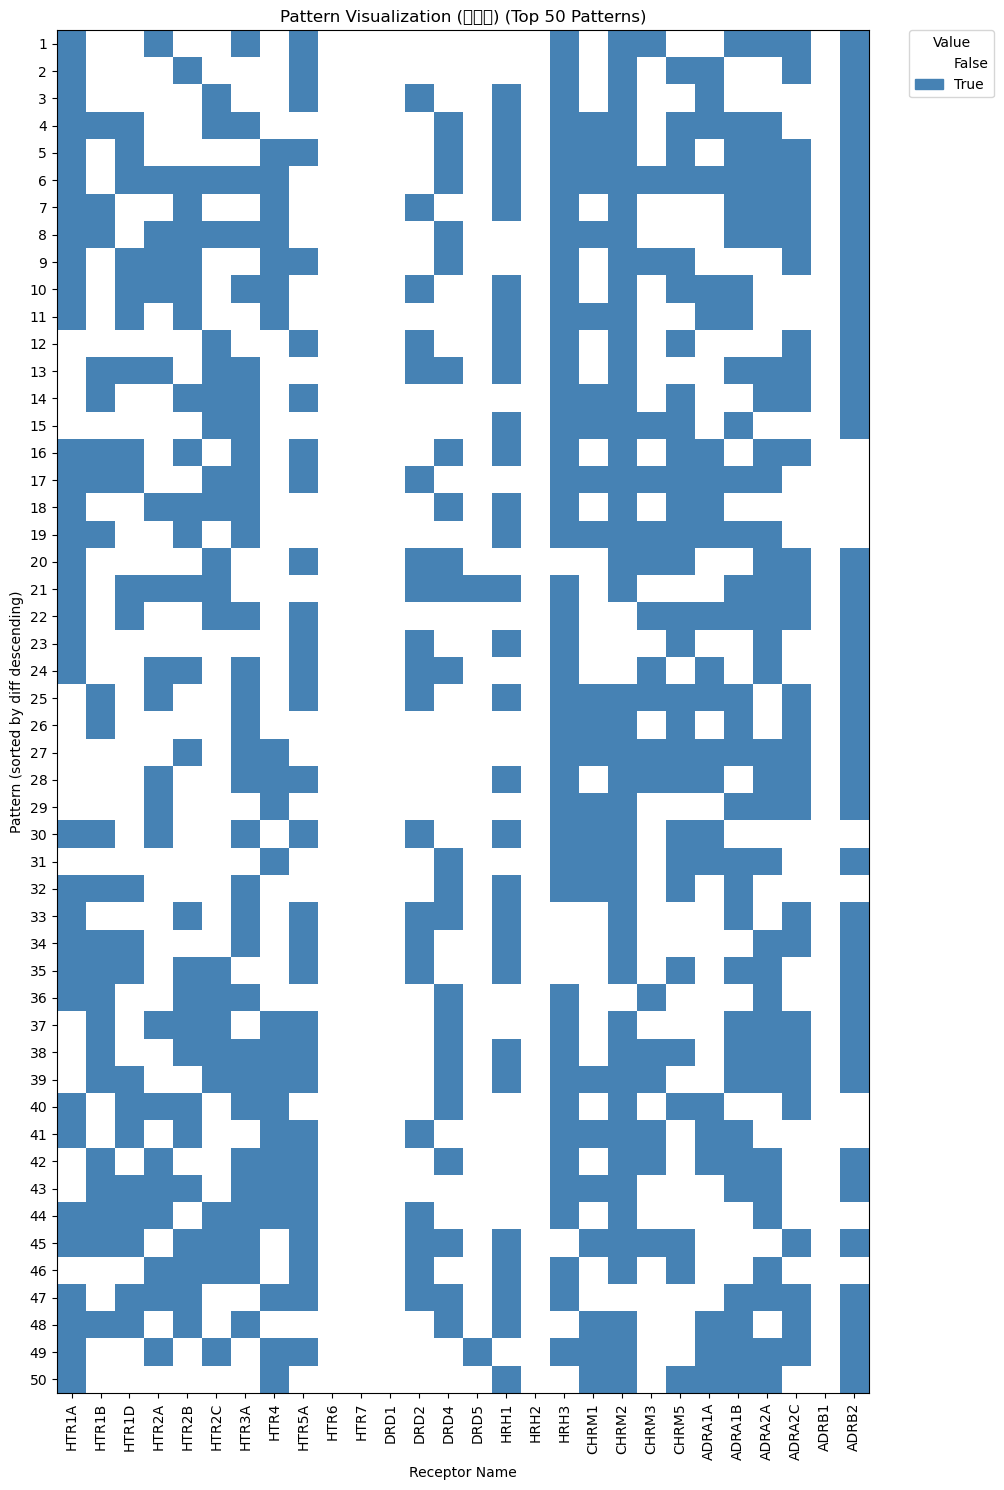

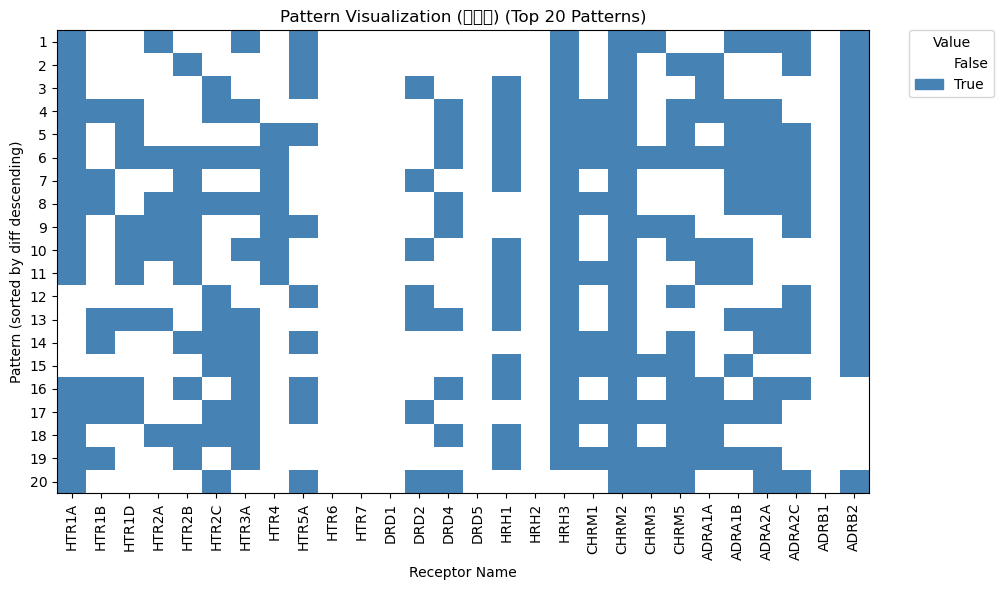

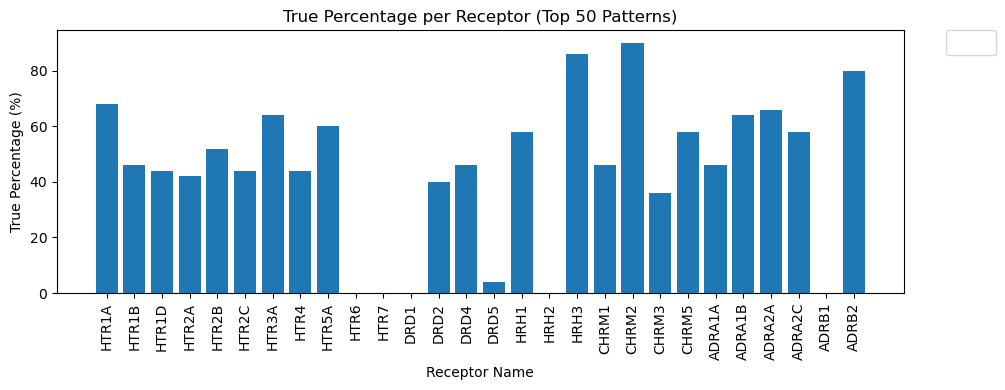

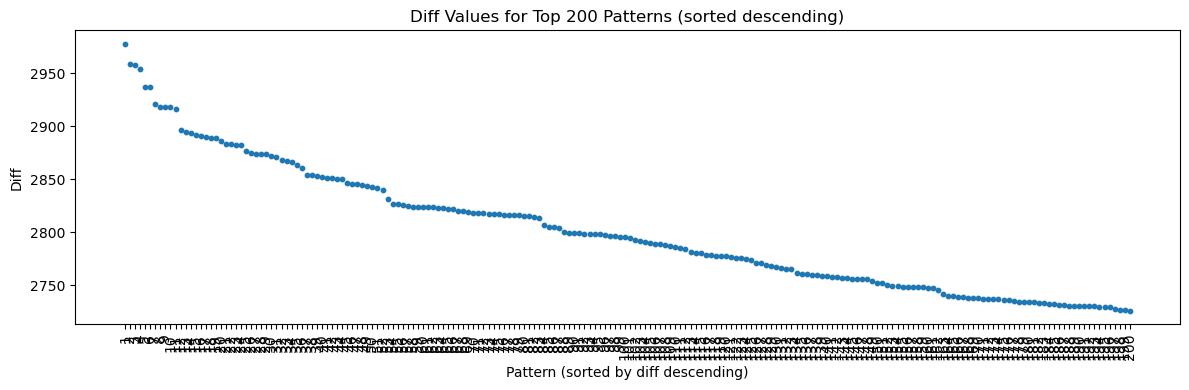

In [10]:
visualize_patterns(results_df_sorted, top_n=50, top_n_for_heatmap=20, scatter_n=200)

In [ ]:
GPCR_type_df=pd.read_csv("/temp/GPCR_df.csv",index_col=0)

In [ ]:
GPCR_adata_norm_df

In [ ]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt

# 前提：以下の変数は既に定義されているものとする
# adata: シングルセル解析の AnnData オブジェクト（obs に "is_clz_selective" などが含まれる）
# GPCR_adata_norm_df: 正規化済み GPCR 発現データの DataFrame（行=細胞, 列=受容体名）
# GPCR_type_df: 受容体タイプの DataFrame（列: receptor_name, type）; type は "Gs", "Gi" 等
# drug_list: 薬剤名のリスト（例: ["drugA", "drugB", ...]）
# drug_conc: 薬剤濃度（scalar）
# ※ D_R_mtx は本コードでは使用せず、effective Ki 値によりシミュレーションする

# 1. adata.obs の "is_clz_selective" に基づき、グループ分けするためのマスクを作成
mask = adata.obs['is_clz_selective'] == True

# 2. GPCRのリストおよび GPCR_type_df のフィルタリング
GPCR_list2 = GPCR_adata_norm_df.columns
GPCR_type_df = GPCR_type_df[GPCR_type_df.receptor_name.isin(GPCR_list2)]
Gs = GPCR_type_df[GPCR_type_df.type == "Gs"]["receptor_name"].values
Gi = GPCR_type_df[GPCR_type_df.type == "Gi"]["receptor_name"].values

# 3. ランダムな受容体阻害パターンを 10,000 パターン生成
unique_patterns_set = set()
pattern_dict = {}
i = 0
while len(unique_patterns_set) < 10000:
    random_pattern = np.random.randint(2, size=len(GPCR_list2))
    pattern_str = ''.join(map(str, random_pattern))
    if pattern_str not in unique_patterns_set:
        unique_patterns_set.add(pattern_str)
        # 各パターンは、受容体ごとに True (阻害する) / False (阻害しない) の辞書とする
        pattern_dict[f"Pattern_{i+1}"] = {gpcr: bool(val) for gpcr, val in zip(GPCR_list2, random_pattern)}
        i += 1

# オプション：最初の5パターンを確認
for key in list(pattern_dict.keys())[:5]:
    print(f"{key}: {pattern_dict[key]}")

# 4. 全細胞の GPCR 発現データ（正規化済み）の DataFrame を用意
# ※ GPCR_adata_norm_df の index と adata.obs_names が整合している前提
all_expr = pd.DataFrame(GPCR_adata_norm_df, index=GPCR_adata_norm_df.index, columns=GPCR_list2)

# 5. 全細胞に対する cAMP 変化（cAMP modulation）をシミュレーションする関数の定義
def simulate_drug_response_all(expression_df, pattern, drug_list, drug_conc, Gs, Gi):
    """
    expression_df: 各細胞の受容体発現 (DataFrame, 行=細胞, 列=受容体)
    pattern: 受容体阻害パターン（辞書, receptor -> bool, True=阻害する）
    drug_list: 薬剤名のリスト
    drug_conc: 薬剤濃度（scalar）
    Gs, Gi: Gs, Gi タイプ受容体名の配列
    """
    # 阻害パターンに応じた effective Ki の設定
    # 阻害する受容体は Ki = 0.01、阻害しない受容体は Ki = 10000
    effective_Ki = pd.Series({receptor: (0.01 if pattern[receptor] else 10000)
                              for receptor in expression_df.columns})
    
    responses = {}
    for drug in drug_list:
        # 各薬剤について、Gs 効果・Gi 効果を計算
        gs_effect = (expression_df[Gs].divide(1 + drug_conc / effective_Ki[Gs])).sum(axis=1)
        gi_effect = (expression_df[Gi].divide(1 + drug_conc / effective_Ki[Gi])).sum(axis=1)
        basal_cAMP = (expression_df[Gs] - expression_df[Gi]).sum(axis=1)
        cAMPmod = (gs_effect - gi_effect) - basal_cAMP
        # 各薬剤の結果は、細胞ごとの cAMPmod の Series とする
        responses[drug] = cAMPmod
    return responses

# 6. 各阻害パターンについて、全細胞でシミュレーションした後、clz_selective と非選択細胞間の差分を算出
results = []
for pattern_name, pattern in pattern_dict.items():
    # 全細胞でのシミュレーション結果を得る
    all_responses = simulate_drug_response_all(all_expr, pattern, drug_list, drug_conc, Gs, Gi)
    
    diff = {}
    for drug in drug_list:
        # clz_selective 細胞群の平均 cAMPmod
        selective_mean = all_responses[drug][mask].mean()
        # 非選択細胞群の平均 cAMPmod
        nonselective_mean = all_responses[drug][~mask].mean()
        diff[drug] = selective_mean - nonselective_mean
    # 複数薬剤の場合、ここでは平均差を評価指標とする
    mean_diff = np.mean(list(diff.values()))
    results.append({
        'pattern': pattern_name,
        'diff_per_drug': diff,
        'mean_diff': mean_diff
    })

# 7. 結果を DataFrame に変換し、mean_diff の大きい順にソート
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='mean_diff', ascending=False)

# 上位のパターンを確認（例：上位5件）
print(results_df_sorted.head())


In [ ]:
mask = adata.obs['is_clz_selective'] == 1

adata_clz_selective = adata[mask, :]
adata_not_clz_selective = adata[~mask, :]

GPCR_adata_clz_selective = GPCR_adata[mask, :]
GPCR_adata_not_clz_selective = GPCR_adata[~mask, :]

GPCR_list2=GPCR_adata_norm_df.columns
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(GPCR_list2)]

import numpy as np

# 重複を避けるために使用するセット
unique_patterns_set = set()

# 結果を保存するための辞書
pattern_dict = {}

# 1万種類の独自の活性化パターンを生成
i = 0
while len(unique_patterns_set) < 10000:
    # ランダムな活性化パターンを生成（0はFalse、1はTrueとする）
    random_pattern = np.random.randint(2, size=len(GPCR_list2))
    # パターンを文字列に変換してハッシュ可能にする
    pattern_str = ''.join(map(str, random_pattern))

    # このパターンがまだ見つかっていない場合は保存
    if pattern_str not in unique_patterns_set:
        unique_patterns_set.add(pattern_str)
        pattern_dict[f"Pattern_{i+1}"] = {gpcr: bool(val) for gpcr, val in zip(GPCR_list2, random_pattern)}
        i += 1

# 最初の5つのパターンを出力して確認
for key in list(pattern_dict.keys())[:5]:
    print(f"{key}: {pattern_dict[key]}")

# pattern_dictをデータフレームに変換
pattern_df = pd.DataFrame.from_dict(pattern_dict, orient='index').reset_index(drop=True)

clz_s=pd.DataFrame(GPCR_adata_clz_selective.X)
clz_s.columns=GPCR_list2

clz_nons=pd.DataFrame(GPCR_adata_not_clz_selective.X)
clz_nons.columns=GPCR_list2

Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values

clz_s_Gs=clz_s.loc[:,Gs].dot(pattern_df.loc[:,Gs].T)
clz_s_Gi=clz_s.loc[:,Gi].dot(pattern_df.loc[:,Gi].T)
clz_s_cAMP=clz_s_Gi-clz_s_Gs

clz_nons_Gs=clz_nons.loc[:,Gs].dot(pattern_df.loc[:,Gs].T)
clz_nons_Gi=clz_nons.loc[:,Gi].dot(pattern_df.loc[:,Gi].T)
clz_nons_cAMP=clz_nons_Gi-clz_nons_Gs



In [ ]:
sum(adata.obs['is_clz_selective'] ==1)

In [ ]:
mask = adata.obs['is_clz_selective'] == 1

In [ ]:
adata_clz_selective = adata[mask, :]
adata_not_clz_selective = adata[~mask, :]

GPCR_adata_clz_selective = GPCR_adata[mask, :]
GPCR_adata_not_clz_selective = GPCR_adata[~mask, :]

In [ ]:
print(adata_clz_selective.X)
print(adata_clz_selective.X.shape)
print(adata_not_clz_selective.X.shape)

In [ ]:
GPCR_list2=GPCR_adata_norm_df.columns
GPCR_type_df=GPCR_type_df[GPCR_type_df.receptor_name.isin(GPCR_list2)]

In [ ]:
print(GPCR_list2)

In [ ]:
import numpy as np

# 重複を避けるために使用するセット
unique_patterns_set = set()

# 結果を保存するための辞書
pattern_dict = {}

# 1万種類の独自の活性化パターンを生成
i = 0
while len(unique_patterns_set) < 10000:
    # ランダムな活性化パターンを生成（0はFalse、1はTrueとする）
    random_pattern = np.random.randint(2, size=len(GPCR_list2))
    # パターンを文字列に変換してハッシュ可能にする
    pattern_str = ''.join(map(str, random_pattern))

    # このパターンがまだ見つかっていない場合は保存
    if pattern_str not in unique_patterns_set:
        unique_patterns_set.add(pattern_str)
        pattern_dict[f"Pattern_{i+1}"] = {gpcr: bool(val) for gpcr, val in zip(GPCR_list2, random_pattern)}
        i += 1

# 最初の5つのパターンを出力して確認
for key in list(pattern_dict.keys())[:5]:
    print(f"{key}: {pattern_dict[key]}")
    


In [ ]:
# pattern_dictをデータフレームに変換
pattern_df = pd.DataFrame.from_dict(pattern_dict, orient='index').reset_index(drop=True)

In [ ]:
pattern_df

In [ ]:
clz_s=pd.DataFrame(GPCR_adata_clz_selective.X)
clz_s.columns=GPCR_list2

clz_nons=pd.DataFrame(GPCR_adata_not_clz_selective.X)
clz_nons.columns=GPCR_list2

In [ ]:
Gs=GPCR_type_df[GPCR_type_df.type=="Gs"]["receptor_name"].values
Gi=GPCR_type_df[GPCR_type_df.type=="Gi"]["receptor_name"].values
Gq=GPCR_type_df[GPCR_type_df.type=="Gq"]["receptor_name"].values

In [ ]:
#clz_s_Gs=(clz_s.loc[:,Gs]*pattern_df.loc[:,Gs]).sum(axis=0) 
clz_s_Gs=clz_s.loc[:,Gs].dot(pattern_df.loc[:,Gs].T)
clz_s_Gi=clz_s.loc[:,Gi].dot(pattern_df.loc[:,Gi].T)
clz_s_cAMP=clz_s_Gi-clz_s_Gs

clz_nons_Gs=clz_nons.loc[:,Gs].dot(pattern_df.loc[:,Gs].T)
clz_nons_Gi=clz_nons.loc[:,Gi].dot(pattern_df.loc[:,Gi].T)
clz_nons_cAMP=clz_nons_Gi-clz_nons_Gs

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
def compare_and_plot(df_A, df_B, top_x, test_type='t_test', show_first_graph=True):
    # 群内平均値の群間差を計算
    mean_A = df_A.mean()
    mean_B = df_B.mean()
    diff_mean = mean_A - mean_B
    
    # 活性化パターンを群間差が大きい順にソート
    sorted_patterns = diff_mean.sort_values(ascending=False).index[:top_x]

    # 統計テスト
    test_stats = []
    p_values = []
    for pattern in sorted_patterns:
        if test_type == 't_test':
            test_stat, p_val = ttest_ind(df_A.loc[:, pattern], df_B.loc[:, pattern])
        elif test_type == 'u_test':
            test_stat, p_val = mannwhitneyu(df_A.loc[:, pattern], df_B.loc[:, pattern])
        else:
            raise ValueError("Invalid test_type. Choose either 't_test' or 'u_test'")
        
        test_stats.append(test_stat)
        p_values.append(p_val)

    # 第1のグラフ（オプション）
    if show_first_graph:
        plt.figure(figsize=(10, 6))
        plt.bar(mean_A.index, mean_A.values, alpha=0.6, label='Group A')
        plt.bar(mean_B.index, mean_B.values, alpha=0.6, label='Group B')
        plt.title('Mean Activation by Pattern')
        plt.xlabel('Pattern')
        plt.ylabel('Mean Activation')
        plt.legend()
        plt.show()

    # Sort the top_x patterns by their diff_mean, in descending order
    sorted_by_diff_mean = diff_mean[sorted_patterns].sort_values(ascending=False).index

    plt.figure(figsize=(10, 6))
    plt.scatter(range(1, top_x + 1), diff_mean[sorted_by_diff_mean], c='blue', label='Difference in Mean Activation')
    plt.xticks(range(1, top_x + 1), labels=sorted_by_diff_mean, rotation=45)
    plt.title(f'Top {top_x} Patterns with Highest Difference in Mean Activation')
    plt.xlabel('Sorted Pattern')
    plt.ylabel('Difference in Mean Activation')
    plt.legend()
    plt.show()


    return sorted_patterns, test_stats, p_values


In [ ]:
# 関数を呼び出してプロット、統計値とP値を受け取る
sorted_patterns, test_stats, p_values = compare_and_plot(clz_s_cAMP, clz_nons_cAMP,
                                                        top_x=100, test_type='t_test',show_first_graph=False)

print("Statistical values for each pattern:")
print(test_stats)

print("P-values for each pattern:")
print(p_values)

print("Top X patterns:")
print(sorted_patterns)

In [ ]:
top_pattern=pattern_df.iloc[sorted_patterns,:]

In [ ]:
def plot_heatmap_and_average(pattern_df):
    # TrueとFalseを数値に変換（True=1, False=0）
    numeric_df = pattern_df.astype(int)

    # ヒートマップを描画
    plt.figure(figsize=(10, 14))
    plt.subplot(2, 1, 1)  # 2x1のグリッドの1番目
    plt.imshow(pattern_df, cmap='RdBu_r', aspect='auto')

    # カラーバーを追加
    plt.colorbar(ticks=[0, 1], label='Boolean Value')

    # 軸のラベルとタイトルを設定
    plt.title('Pattern vs Receptor Boolean Heatmap')
    plt.xlabel('Receptors')
    plt.ylabel('Patterns')

    # x軸とy軸の目盛りを設定
    plt.xticks(range(len(pattern_df.columns)), pattern_df.columns, rotation=90)
    plt.yticks(range(len(pattern_df.index)), pattern_df.index)

    # 各受容体の論理値の平均値をプロット
    plt.subplot(2, 1, 2)  # 2x1のグリッドの2番目
    average_values = numeric_df.mean()
    plt.bar(average_values.index, average_values.values, color='green')
    plt.title('Average Boolean Value per Receptor')
    plt.xlabel('Receptor')
    plt.ylabel('Average Boolean Value')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()


In [ ]:
# ヒートマップの描画
plot_heatmap_and_average(top_pattern)

In [ ]:
# 関数を呼び出してプロット、統計値とP値を受け取る
sorted_patterns, test_stats, p_values = compare_and_plot(clz_nons_cAMP, clz_s_cAMP,
                                                        top_x=100, test_type='t_test',show_first_graph=False)

print("Statistical values for each pattern:")
print(test_stats)

print("P-values for each pattern:")
print(p_values)

print("Top X patterns:")
print(sorted_patterns)

top_pattern=pattern_df.iloc[sorted_patterns,:]
plot_heatmap_and_average(top_pattern)

In [ ]:
important_receptor=["HTR1B","HRH3","CHRM2","ADRB2"]